In [11]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [12]:
herd = pd.read_csv('penguins.csv')
num_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'
X, y = herd[num_features], herd[target]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Surowy zbiór danych - zbiór treningowy:')
print(X_train[num_features].isnull().mean())
print('Surowy zbiór danych - zbiór testowy:')
print(X_test[num_features].isnull().mean())

Surowy zbiór danych - zbiór treningowy:
CulmenLength     0.007273
CulmenDepth      0.007273
FlipperLength    0.007273
BodyMass         0.007273
dtype: float64
Surowy zbiór danych - zbiór testowy:
CulmenLength     0.0
CulmenDepth      0.0
FlipperLength    0.0
BodyMass         0.0
dtype: float64


In [14]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# transformer = wartości numeryczne  ;)
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
])

data_preparation.fit_transform(X_train)


array([[  35. ,   17.9,  192. , 3725. ],
       [  38.8,   20. ,  190. , 3950. ],
       [  36. ,   17.1,  187. , 3700. ],
       ...,
       [  40.2,   20.1,  200. , 3975. ],
       [  39.7,   17.9,  193. , 4250. ],
       [  40.2,   17.1,  193. , 3400. ]])

In [15]:

metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score_test','F1_score_train','AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked, X_trained,y_trained):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_train= model.predict(X_trained)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric_test = f1_score(y_checked, predictions,average = 'weighted')
    f1_metric_train = f1_score(y_trained, predictions_train,average = 'weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba,multi_class = 'ovo')

    metrics_dataframe = metrics_dataframe.append({
                                                'Model': name,
                                                'F1_score_test': f1_metric_test,
                                                'F1_score_train': f1_metric_train, 
                                                'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



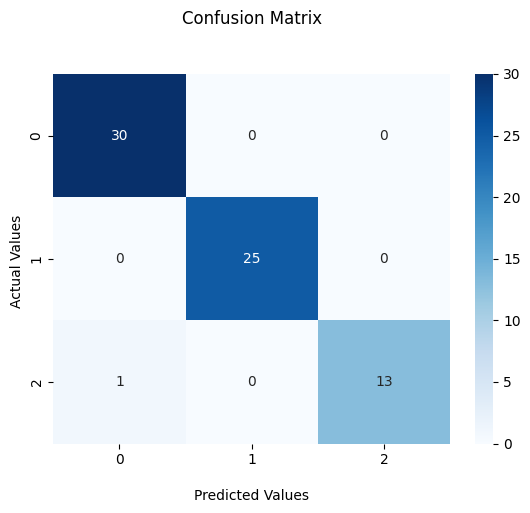

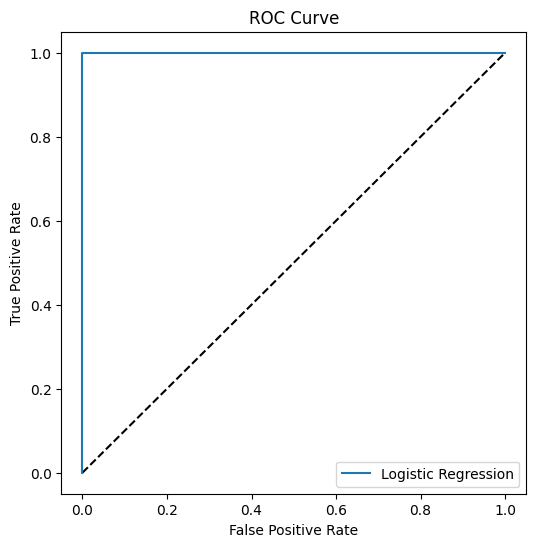

C:\Users\sliwi\AppData\Local\Temp\ipykernel_8392\4250866173.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.985358,0.989104,1.0


In [16]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test, X_train, y_train)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



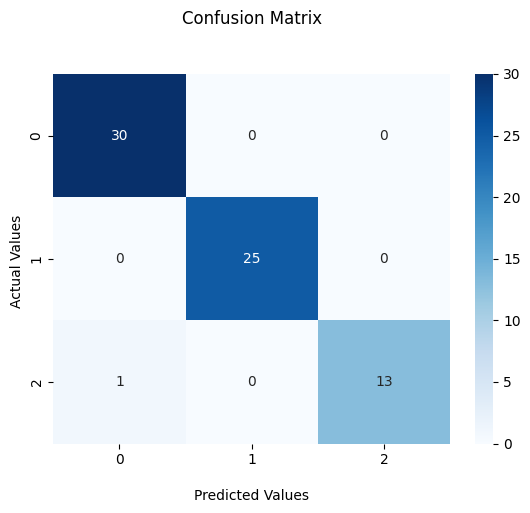

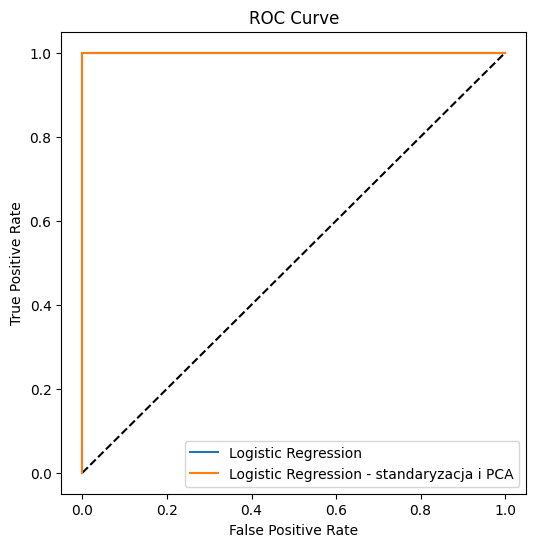

C:\Users\sliwi\AppData\Local\Temp\ipykernel_8392\4250866173.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.985358,0.989104,1.0
1,Logistic Regression - standaryzacja i PCA,0.985358,0.989079,1.0


In [17]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])
# transformer = wartości numeryczne ;)
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])
model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)
calculate_metrics(model_pipeline_v2, 'Logistic Regression - standaryzacja i PCA', X_test, y_test, X_train, y_train)

W poprzednim zadaniu dla modelu Logistic Regression otrzymano ospowiednio
* F1_score_test 	0.970679	
* F1_score_train	0.995803
* AUC 0.999295 ++
Różnica jest niewielka i może wynikać z sposobu w jaki poradzono sobie z wartościami null. W poprzednim zadaniu usunięto dwa puste wiersze, w tym uzupełniono je średnią.

In [18]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [19]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 7.9060432109076855, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.9, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 2}


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



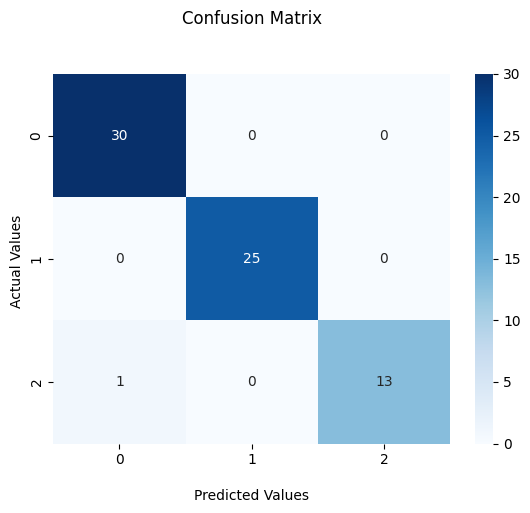

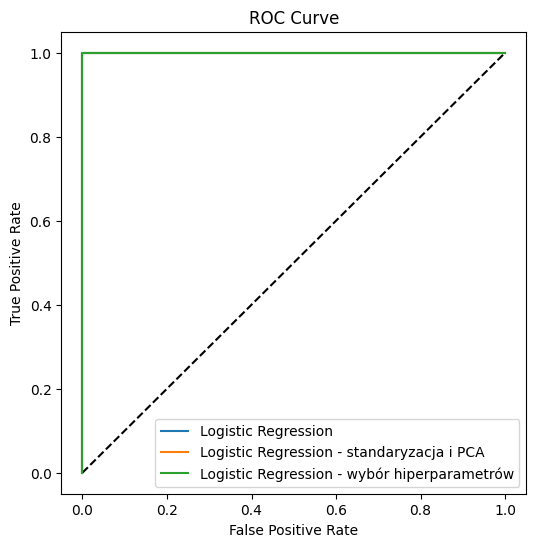

C:\Users\sliwi\AppData\Local\Temp\ipykernel_8392\4250866173.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.985358,0.989104,1.0
1,Logistic Regression - standaryzacja i PCA,0.985358,0.989079,1.0
2,Logistic Regression - wybór hiperparametrów,0.985358,0.992731,1.0


In [20]:
calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test, X_train, y_train)